In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="llama-3.3-70b-versatile")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result

AIMessage(content='Hello. How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 36, 'total_tokens': 46, 'completion_time': 0.010300801, 'prompt_time': 0.010514936, 'queue_time': 0.043506603, 'total_time': 0.020815737}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ddfbb0da0', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--a6d981bf-c338-4276-9cf2-6554cbfe3356-0', usage_metadata={'input_tokens': 36, 'output_tokens': 10, 'total_tokens': 46})

In [3]:
### Custom tools
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools=[add,multiply,divide]
tools



[<function __main__.add(a: int, b: int) -> int>,
 <function __main__.multiply(a: int, b: int) -> int>,
 <function __main__.divide(a: int, b: int) -> float>]

In [4]:
## Integrate tools with llm
llm_with_tools=llm.bind_tools(tools)
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000018644DF2B50>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000018644F3AAD0>, model_name='llama-3.3-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'add', 'description': 'Adds a and b.', 'parameters': {'properties': {'a': {'description': 'first int', 'type': 'integer'}, 'b': {'description': 'second int', 'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'multiply', 'description': 'Multiply a and b.', 'parameters': {'properties': {'a': {'description': 'first int', 'type': 'integer'}, 'b': {'description': 'second int', 'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'divide', 'description': 'Divide a by b.', 'parameters': {'properties': {'a': {'description': 'fi

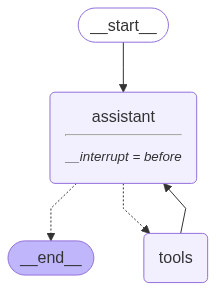

In [5]:
### WWorkflow with Langgraph
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from langchain_core.messages import AIMessage,HumanMessage,SystemMessage

## system Message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

## node definition
def assistant(state:MessagesState):
    return {"messages":[llm_with_tools.invoke([sys_msg] + state["messages"])]}

#Graph
builder=StateGraph(MessagesState)

## Define nodes: 
builder.add_node("assistant",assistant)
builder.add_node("tools",ToolNode(tools))

## Define the Edges

builder.add_edge(START,"assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,

)
builder.add_edge("tools","assistant")

memory=MemorySaver()

### human in the loop
graph=builder.compile(interrupt_before=["assistant"],checkpointer=memory)

# Show
display(Image(graph.get_graph().draw_mermaid_png()))






In [6]:
thread={"configurable":{"thread_id":"123"}}
initial_input={"messages":HumanMessage(content="Multiply 2 and 3")}

In [7]:
for event in graph.stream(initial_input,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


In [8]:
state=graph.get_state(thread)
state.next

('assistant',)

In [9]:
graph.get_state_history(thread)

<generator object Pregel.get_state_history at 0x00000186460DD900>

In [10]:
state

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='207cab32-78e4-46e1-844f-aacd119b54bc')]}, next=('assistant',), config={'configurable': {'thread_id': '123', 'checkpoint_ns': '', 'checkpoint_id': '1f0799bb-f94e-6e14-8000-e495db526b06'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-08-15T05:50:28.958568+00:00', parent_config={'configurable': {'thread_id': '123', 'checkpoint_ns': '', 'checkpoint_id': '1f0799bb-f93a-6888-bfff-0215058b1e86'}}, tasks=(PregelTask(id='f71ee025-9359-07ad-f9e7-4bbe88704330', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=())

In [11]:
## Continue the execution to Assistant
for event in graph.stream(None,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (n607qse8d)
 Call ID: n607qse8d
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6


In [12]:
state=graph.get_state(thread)
state.next

('assistant',)

In [15]:
## Continue the execution of Assistant and then end
for event in graph.stream(None,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


### Edit Human Feedback

In [16]:
initial_input={"messages":HumanMessage(content="Multiply 2 and 3")}

thread={"configurable":{"thread_id":"1"}}
for event in graph.stream(initial_input,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


In [17]:
state

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='207cab32-78e4-46e1-844f-aacd119b54bc'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'n607qse8d', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 373, 'total_tokens': 392, 'completion_time': 0.042960689, 'prompt_time': 0.034243935, 'queue_time': 0.050854172, 'total_time': 0.077204624}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ddfbb0da0', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--b9852617-21d5-4b72-9e6f-e9f144b17df7-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'n607qse8d', 'type': 'tool_call'}], usage_metadata={'input_tokens': 373, 'output_tokens': 19, 'total_tokens': 392}), ToolMessage(content='6', name='multiply', id='d1d74606-63d5-4abe

In [18]:
state=graph.get_state(thread)
state.next

('assistant',)

In [19]:
graph.update_state(thread,{"messages":[HumanMessage(content="No,please multiply 15 and 6")]})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0799da-b093-6a77-8001-e4a79580be75'}}

In [20]:
new_state=graph.get_state(thread).values

for m in new_state['messages']:
    m.pretty_print()


================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

No,please multiply 15 and 6


In [21]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

No,please multiply 15 and 6
================================== Ai Message ==================================
Tool Calls:
  multiply (pvw9yfx39)
 Call ID: pvw9yfx39
  Args:
    a: 15
    b: 6
================================= Tool Message =================================
Name: multiply

90


In [22]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

90
================================== Ai Message ==================================

The result of multiplying 15 and 6 is 90.
